# Estimating water saving from ET Reduction in Areas deemed highly

suitable for thinning to enhance recharge (Suitability \>= 7)

This notebook:

1.  Loads your **suitability** raster (values 0–10, float).

2.  Masks pixels with **value \> 6.99**.

3.  Computes **area** of these pixels (reprojects to equal-area CRS if
    needed).

4.  Calculates **daily water savings** if thinning reduces ET from
    **0.00365 m/day** to **0.00258 m/day** (*ΔET = 0.00107 m/day*).

5.  Plots the **high-suitability mask** over a **basemap of Arizona**.

6.  Writes a small **CSV summary** of the results.

> Assumptions: ET rates are spatially uniform within the selected
> pixels; pixel area is computed in an equal-area CRS for accuracy.

In [1]:
## install packages
#!pip install rasterio geopandas shapely pyproj contextily matplotlib numpy
#!pip install contextily

## 1) Configuration

Set the path to your suitability raster and ET parameters. The raster
path below uses your Windows path.

In [2]:
from pathlib import Path

# --- User inputs ---
RASTER_PATH = Path(r"C:\Users\rl587\Documents\ArcGIS\Projects\ThinningRechargePonderosa_v02_2025\Suitability_out.tif")

# ET rates (meters/day)
ET_non_thinned = 0.00365   # average ET in non-thinned areas
ET_thinned     = 0.00258   # average ET in thinned areas
delta_ET       = ET_non_thinned - ET_thinned  # expected savings per day

# Suitability threshold
THRESH = 6.99   # strictly greater than 6.99 (GTE 7.0)
 
print(f"Raster path: {RASTER_PATH}")
print(f"ΔET (m/day): {delta_ET:.8f}")

Raster path: C:\Users\rl587\Documents\ArcGIS\Projects\ThinningRechargePonderosa_v02_2025\Suitability_out.tif
ΔET (m/day): 0.00107000

## 2) Load raster and inspect metadata

We load the suitability raster with `rasterio`, inspect the CRS and
pixel size, and identify no-data values.

In [3]:

import rasterio
import numpy as np

with rasterio.open(RASTER_PATH) as src:
    data = src.read(1)  # first band
    profile = src.profile.copy()
    crs = src.crs
    transform = src.transform
    nodata = src.nodata
    res = src.res  # (xres, yres)
    
print("CRS:", crs)
print("Resolution (x, y):", res)
print("Transform:", transform)
print("Nodata value:", nodata)
print("Array shape (rows, cols):", data.shape)
print("Data range (min, max):", np.nanmin(data), np.nanmax(data))


CRS: EPSG:6341
Resolution (x, y): (30.0, 30.0)
Transform: | 30.00, 0.00, 27232.83|
| 0.00,-30.00, 4253973.34|
| 0.00, 0.00, 1.00|
Nodata value: nan
Array shape (rows, cols): (29080, 29318)
Data range (min, max): 1.00002 8.886681

## 3) Ensure equal-area units for area calculations

If the raster is in a geographic CRS (units in degrees), we reproject it
to **EPSG:5070** (NAD83 / Conus Albers), which is an equal-area
projection suitable for the U.S.

In [4]:

import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

def reproject_to_equal_area(array, src_profile, dst_crs="EPSG:5070", resampling=Resampling.nearest):
    src_crs = src_profile["crs"]
    src_transform = src_profile["transform"]
    src_height = src_profile["height"]
    src_width = src_profile["width"]
    
    dst_transform, dst_width, dst_height = calculate_default_transform(
        src_crs, dst_crs, src_width, src_height, *rasterio.transform.array_bounds(src_height, src_width, src_transform)
    )
    dst_profile = src_profile.copy()
    dst_profile.update({
        "crs": dst_crs,
        "transform": dst_transform,
        "width": dst_width,
        "height": dst_height,
        "dtype": array.dtype
    })
    
    dst = np.empty((dst_height, dst_width), dtype=array.dtype)
    reproject(
        source=array,
        destination=dst,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=resampling,
        src_nodata=src_profile.get("nodata", None),
        dst_nodata=src_profile.get("nodata", None),
    )
    return dst, dst_profile

# Determine whether CRS is projected (meters) or geographic (degrees)
with rasterio.open(RASTER_PATH) as src:
    is_geographic = (src.crs is None) or (not src.crs.is_projected)
    
if is_geographic:
    print("Input CRS appears geographic (degrees). Reprojecting to EPSG:5070 for area calculations...")
    with rasterio.open(RASTER_PATH) as src:
        data = src.read(1)
        profile = src.profile.copy()
    data_aeq, profile_aeq = reproject_to_equal_area(data, profile, "EPSG:5070")
else:
    print("Input CRS is projected (likely meters). Using as-is for area calculations.")
    with rasterio.open(RASTER_PATH) as src:
        data_aeq = src.read(1)
        profile_aeq = src.profile.copy()

# Convenience variables in equal-area space
aeq_res = profile_aeq["transform"].a, -profile_aeq["transform"].e  # approximate x/y pixel sizes
pixel_area_m2 = abs(aeq_res[0] * aeq_res[1])
print("Equal-area pixel size (approx):", aeq_res, "m")
print("Pixel area (m^2):", pixel_area_m2)


Input CRS is projected (likely meters). Using as-is for area calculations.
Equal-area pixel size (approx): (30.0, 30.0) m
Pixel area (m^2): 900.0

## 4) Select high-suitability pixels and compute area

We select pixels with **value \> 6.99**, exclude no-data, and compute
total area as `count * pixel_area`. We also report hectares.

In [5]:

# Handle nodata
nodata_aeq = profile_aeq.get("nodata", None)

arr = data_aeq.astype("float64")
if nodata_aeq is not None:
    arr = np.where(arr == nodata_aeq, np.nan, arr)

mask_high = arr > THRESH  # strictly greater than 7

count_pixels = np.count_nonzero(mask_high & ~np.isnan(arr))
total_area_m2 = count_pixels * pixel_area_m2
total_area_ha = total_area_m2 / 10_000.0

print(f"High-suitability pixels (> {THRESH}): {count_pixels:,}")
print(f"Total area: {total_area_m2:,.2f} m²  ({total_area_ha:,.2f} ha)")

High-suitability pixels (> 6.99): 2,065,379
Total area: 1,858,841,100.00 m²  (185,884.11 ha)

## 5) Compute daily water savings

We use the ET difference:

$\Delta ET = 0.00365 - 0.00258 = 0.00107$ m/day.

Daily water savings = $\Delta ET \times \text{area}$.

In [6]:

DELTA_ET = delta_ET  # m/day

# Volumes
volume_m3_per_day = DELTA_ET * total_area_m2  # 1 m * m² = m³
ACRE_FT_PER_M3 = 1.0 / 1233.48184  # ac-ft per m³
volume_acft_per_day = volume_m3_per_day * ACRE_FT_PER_M3

print(f"ΔET (m/day): {DELTA_ET:.8f}")
print(f"Water saved per day: {volume_m3_per_day:,.2f} m³/day  (~{volume_acft_per_day:,.2f} ac-ft/day)")


ΔET (m/day): 0.00107000
Water saved per day: 1,988,959.98 m³/day  (~1,612.48 ac-ft/day)

## 6) Add uncertainty to the ET calculation

incorporate your standard deviations (0.9 mm for thinned, 1.1 mm for
unthinned)

In [7]:
# --- Uncertainty calculation (add ± std) ---
std_non_thinned = 0.0011  # m/day (1.1 mm/day)
std_thinned     = 0.0009  # m/day (0.9 mm/day)

# Max and min delta_ET based on uncertainty
delta_ET_max = (ET_non_thinned + std_non_thinned) - (ET_thinned - std_thinned)
delta_ET_min = (ET_non_thinned - std_non_thinned) - (ET_thinned + std_thinned)

# Corresponding recharge volume ranges (m³/day)
volume_m3_day_max = delta_ET_max * total_area_m2
volume_m3_day_min = delta_ET_min * total_area_m2

print(f"Recharge volume range: {volume_m3_day_min:,.2f} to {volume_m3_day_max:,.2f} m³/day")


Recharge volume range: -1,728,722.22 to 5,706,642.18 m³/day

In [11]:
def convert_volume(value, from_unit="m3", to_unit="acft"):
    """
    Convert between cubic meters (m3) and acre-feet (acft).
    
    Parameters
    ----------
    value : float or array-like
        The volume to convert.
    from_unit : str, default 'm3'
        The unit of the input value ('m3' or 'acft').
    to_unit : str, default 'acft'
        The unit of the output value ('m3' or 'acft').

    Returns
    -------
    float or array-like
        Converted volume.
    """
    m3_per_acft = 1233.48184  # exact conversion

    if from_unit == "m3" and to_unit == "acft":
        return value / m3_per_acft
    elif from_unit == "acft" and to_unit == "m3":
        return value * m3_per_acft
    elif from_unit == to_unit:
        return value
    else:
        raise ValueError("Units must be 'm3' or 'acft'.")
    
minacft = convert_volume(volume_m3_day_min, from_unit="m3", to_unit="acft")
maxacft =convert_volume(volume_m3_day_max, from_unit="m3", to_unit="acft")


print(f"Recharge volume range: {minacft} AcreFeet/day  to {maxacft} acreFeet/day with a mean value of {volume_acft_per_day}")

Recharge volume range: -1401.4979117973874 AcreFeet/day  to 4626.450095933313 acreFeet/day with a mean value of 1612.4760920679632

## 7) Plot high-suitability mask

We plot the binary mask (value 1 where suitability \> 6.99, else 0)
using the raster’s current CRS and transform.

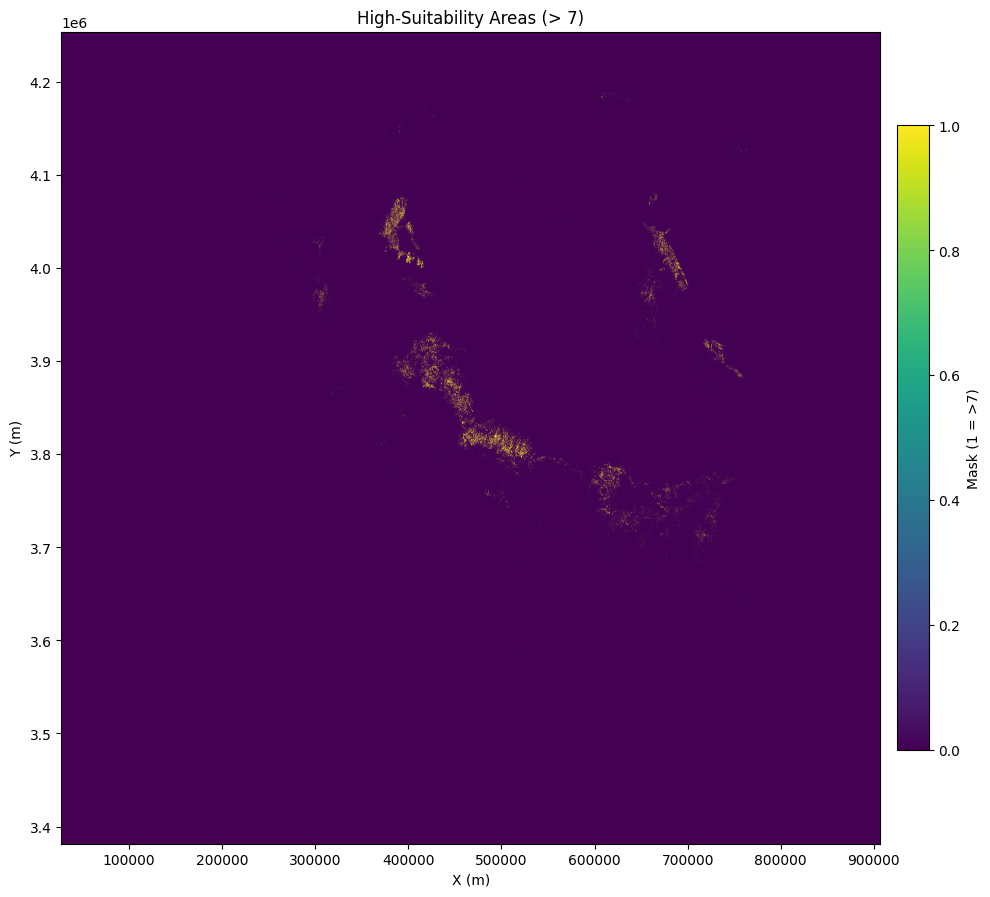

In [10]:

import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import plotting_extent

# Build/reuse a binary mask in the same grid used for area calc (profile_aeq)
# If you already created `mask_high` in Step 4, you can reuse it; otherwise:
binary_mask = np.zeros_like(arr, dtype="float32")
binary_mask[np.isfinite(arr) & (arr > THRESH)] = 1.0

# Compute plot extent from the transform (left, right, bottom, top)
extent = plotting_extent(binary_mask, profile_aeq["transform"])

# Axis labels based on projected vs geographic units
units = "m"
try:
    if profile_aeq["crs"] is not None and not profile_aeq["crs"].is_projected:
        units = "deg"
except Exception:
    pass

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(binary_mask, extent=extent, origin="upper", alpha=1)
ax.set_title("High-Suitability Areas (> 7)")
ax.set_xlabel(f"X ({units})")
ax.set_ylabel(f"Y ({units})")

# Optional: show a tiny colorbar for the mask (1 = selected)
cbar = plt.colorbar(im, ax=ax, fraction=0.036, pad=0.02)
cbar.set_label("Mask (1 = >7)")

plt.tight_layout()
plt.show()


## 8) Save results

Write a small CSV with the key metrics.

In [9]:
import pandas as pd

# Assuming you already calculated:
# delta_ET_max, delta_ET_min, volume_m3_day_max, volume_m3_day_min
# and also have conversion for acre-feet/day:
m3_to_acft = 0.000810713  # 1 m³ = 0.000810713 acre-feet
volume_acft_day_max = volume_m3_day_max * m3_to_acft
volume_acft_day_min = volume_m3_day_min * m3_to_acft

out = pd.DataFrame([{
    "threshold": THRESH,
    "delta_ET_m_per_day": DELTA_ET,
    "pixel_area_m2": pixel_area_m2,
    "count_pixels": int(count_pixels),
    "area_m2": float(total_area_m2),
    "area_hectares": float(total_area_ha),
    "volume_m3_per_day_saved": float(volume_m3_per_day),
    "volume_acft_per_day_saved": float(volume_acft_per_day),
    "volume_m3_per_day_saved_min": float(volume_m3_day_min),
    "volume_m3_per_day_saved_max": float(volume_m3_day_max),
    "volume_acft_per_day_saved_min": float(volume_acft_day_min),
    "volume_acft_per_day_saved_max": float(volume_acft_day_max),
}])

csv_path = "et_thinning_savings_summary.csv"
out.to_csv(csv_path, index=False)
csv_path



'et_thinning_savings_summary.csv'

------------------------------------------------------------------------

### Notes & Caveats

-   **CRS**: Accurate area requires an equal-area projection. This
    notebook reprojects to **EPSG:5070** if your input is geographic
    (degrees).
-   **Edge effects**: We treat each selected pixel uniformly and ignore
    edge effects or sub-pixel variation.
-   **ET assumptions**: ET values are assumed spatially uniform for the
    selected pixels (\>6.99). If you have spatially varying ET,
    substitute a raster of ET differences.
-   **Performance**: For very large rasters, consider chunked/block
    processing with `rasterio` windows to reduce memory usage.